In [1]:
# Import the relavant libraries for logging in

from huggingface_hub import HfApi, HfFolder
import getpass

# get your account token from https://huggingface.co/settings/tokens
token = getpass.getpass("Enter token: ")

# set api for login and save token
api=HfApi()
api.set_access_token(token)
folder = HfFolder()
folder.save_token(token)
print("Login attempted. Token saved.")

Enter token:  ········


Login attempted. Token saved.


In [2]:
# Import required libraries for model

import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.hub_utils import init_git_repo, push_to_hub
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [3]:
# Pretrained model
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}

In [4]:
# Scrape the image links from a target repo

import time
import bs4 as bs4
import requests

urls = []
# load = requests.get("https://github.com/awwalm/MSAStyle/blob/master/Core/Images.md")
load = requests.get("https://github.com/awwalm/MLDataSci/blob/master/MSA/Brittany/Images.md")
soup = bs4.BeautifulSoup(load.content, "html.parser") if load.status_code == 200 else None
if soup is not None:
    article = soup.find("article")
    for a in article.find_all("a"):
        if a.img:
            urls.append(a.img["src"])
urls = urls[:30]
print(f"images collected: {len(urls)}")
print(*urls, sep="\n")

images collected: 8
https://user-images.githubusercontent.com/67423428/198583072-9ecee047-86b8-4740-8db5-df1a72554815.png
https://user-images.githubusercontent.com/67423428/198583084-283a818b-cda6-4f13-b023-9d5cdfccf9ef.png
https://user-images.githubusercontent.com/67423428/198583085-ddff3984-5b2b-4841-b947-0e54187cc16c.png
https://user-images.githubusercontent.com/67423428/198583089-da2880ac-4ffa-4e1e-94a3-f9bc81a48374.png
https://user-images.githubusercontent.com/67423428/198583090-a728e800-5608-41cb-ad79-34de118588c7.png
https://user-images.githubusercontent.com/67423428/198583092-14083220-d513-45fc-8aac-a463471e3f81.png
https://user-images.githubusercontent.com/67423428/198583097-dd2a54b9-0fee-4375-a813-790bf7997fd4.png
https://user-images.githubusercontent.com/67423428/198583101-91f8534a-fdef-4ec5-baab-84c547e7b835.png


In [6]:
# What to teach
what_to_teach = "object" #@param ["object", "style"]

In [14]:
placeholder_token = "<msa_brittany>" #@param {type:"string"}
initializer_token = "brittany" #@param {type:"string"}

In [8]:
# Save path
save_path = "./brittany_concept"

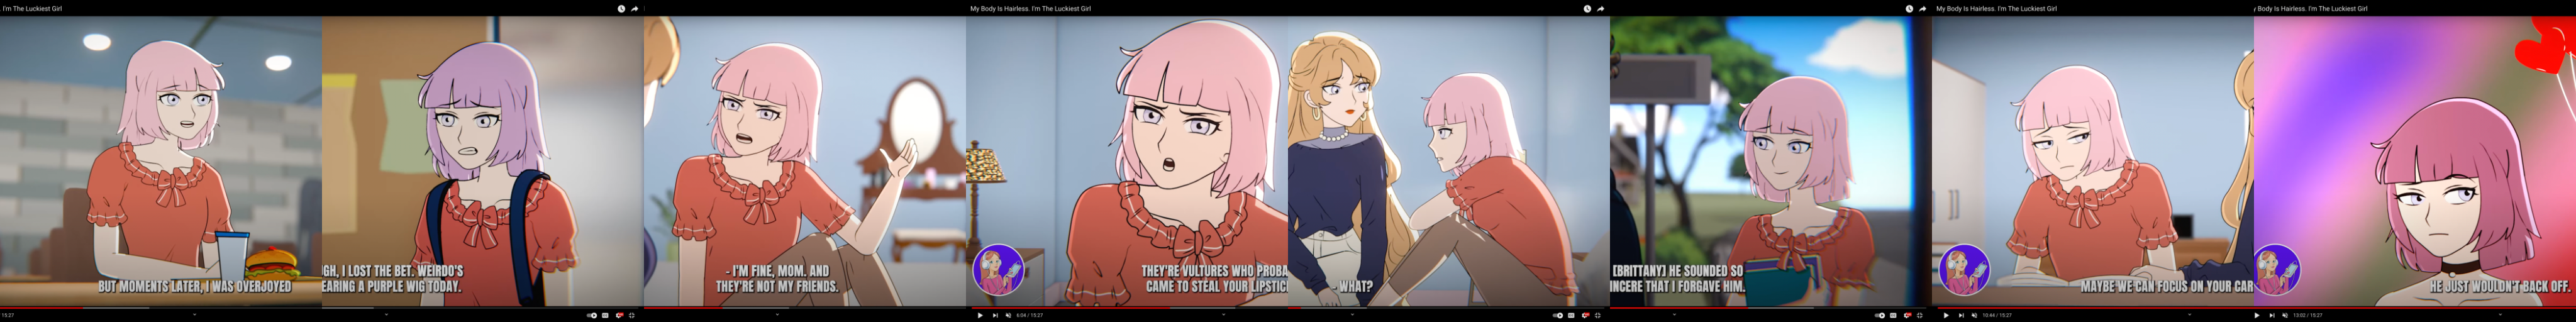

In [9]:
import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

images = list(filter(None,[download_image(url) for url in urls]))
save_path = "./brittany_concept"
if not os.path.exists(save_path):
  os.mkdir(save_path)
[image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]
image_grid(images, 1, len(images))

In [10]:
# Setup the prompt templates for training 

imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]

In [11]:
# Setup the dataset

class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="object",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL.Image.LINEAR,
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

In [15]:
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    print("Error occured:\t")
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

In [16]:
# Convert the initializer_token, placeholder_token to ids

token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

In [17]:
# Load models and create wrapper for stable diffusion

text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)

In [18]:
text_encoder.resize_token_embeddings(len(tokenizer))

Embedding(49409, 768)

In [19]:
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

In [20]:
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

In [21]:
train_dataset = TextualInversionDataset(
      data_root=save_path,
      tokenizer=tokenizer,
      size=512,
      placeholder_token=placeholder_token,
      repeats=100,
      learnable_property=what_to_teach, #Option selected above between object and style
      center_crop=False,
      set="train",
)

/tmp/ipykernel_134746/1491887801.py:35: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  "linear": PIL.Image.LINEAR,
/tmp/ipykernel_134746/1491887801.py:36: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  "bilinear": PIL.Image.BILINEAR,
/tmp/ipykernel_134746/1491887801.py:37: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  "bicubic": PIL.Image.BICUBIC,
/tmp/ipykernel_134746/1491887801.py:38: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  "lanczos": PIL.Image.LANCZOS,


In [23]:
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

In [24]:
noise_scheduler = DDPMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000, tensor_format="pt"
)

In [31]:
hyperparameters = {
    "learning_rate": 5e-04,
    "scale_lr": True,
    "max_train_steps": 3000,
    "train_batch_size": 1,
    "gradient_accumulation_steps": 2,
    "seed": 42,
    "output_dir": "brittany-concept-output"
}

In [29]:
def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)

    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps #, split_batches=True
    )

    # accelerator.state.distributed_type = DistributedType.MULTI_GPU
    # accelerator.state.num_processes = 5

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
        lr=learning_rate,
    )


    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )

    # Move vae and unet to device
    vae.to(accelerator.device)
    unet.to(accelerator.device)

    # Keep vae and unet in eval model as we don't train these
    vae.eval()
    unet.eval()

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    
    print(f"""
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps
    total_batch_size = {train_batch_size} * {accelerator.num_processes} * {gradient_accumulation_steps}
    total_batch_size = {total_batch_size}
    
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_update_steps_per_epoch = math.ceil({len(train_dataloader)} / {gradient_accumulation_steps})
    num_update_steps_per_epoch = {num_update_steps_per_epoch}
    
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)
    num_train_epochs = math.ceil({max_train_steps} / {num_update_steps_per_epoch})
    num_train_epochs = {num_train_epochs}
    
    Num examples = {len(train_dataset)}
    Instantaneous batch size per device = {train_batch_size}"
    Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}
    Gradient Accumulation steps = {gradient_accumulation_steps}
    Total optimization steps = {max_train_steps}
    """)
    
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"]).latent_dist.sample().detach()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                # Get the index for tokens that we want to zero the grads for
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()


    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline(
            text_encoder=accelerator.unwrap_model(text_encoder),
            vae=vae,
            unet=unet,
            tokenizer=tokenizer,
            scheduler=PNDMScheduler(
                beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True
            ),
            safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
            feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"),
        )
        pipeline.save_pretrained(output_dir)
        # Also save the newly trained embeddings
        learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
        learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
        torch.save(learned_embeds_dict, os.path.join(output_dir, "brittany_learned_embeds.bin"))


In [32]:
import accelerate
# from accelerate.utils import DistributedType
# import torch.distributed as dist
# import os
import time

# """ Still won't parallelize for some reason
t0 = time.time()

print(f"Training model with 3000 steps at start time: {t0}")
# os.environ['MKL_SERVICE_FORCE_INTEL'] = '1'
accelerate.notebook_launcher(training_function(text_encoder, vae, unet), args=(), num_processes=1)
print(f"Time taken: {time.time() - t0}")
print(f"Steps/second: {(time.time() - t0)/3000}")
# """

Training model with 3000 steps at start time: 1666963962.5008934

    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps
    total_batch_size = 1 * 1 * 2
    total_batch_size = 2
    
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_update_steps_per_epoch = math.ceil(800 / 2)
    num_update_steps_per_epoch = 400
    
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)
    num_train_epochs = math.ceil(3000 / 400)
    num_train_epochs = 8
    
    Num examples = 800
    Instantaneous batch size per device = 1"
    Total train batch size (w. parallel, distributed & accumulation) = 2
    Gradient Accumulation steps = 2
    Total optimization steps = 3000
    


  0%|          | 0/3000 [00:00<?, ?it/s]

Launching training on one GPU.


TypeError: 'NoneType' object is not callable

In [33]:
#@title Set up the pipeline 
pipe = StableDiffusionPipeline.from_pretrained(
    hyperparameters["output_dir"],
    torch_dtype=torch.float16,
).to("cuda")

In [34]:
#@title Disable overreactive NSFW filter
def dummy_checker(images, **kwargs): return images, False
pipe.safety_checker = dummy_checker

  0%|          | 0/101 [00:00<?, ?it/s]

3 images generated in: 18.496209859848022 (6.165403286616008s/img)


  0%|          | 0/101 [00:00<?, ?it/s]

3 images generated in: 18.61883807182312 (6.206279357274373s/img)


  0%|          | 0/101 [00:00<?, ?it/s]

3 images generated in: 18.83660888671875 (6.27886962890625s/img)
Total time taken: 55.95215082168579


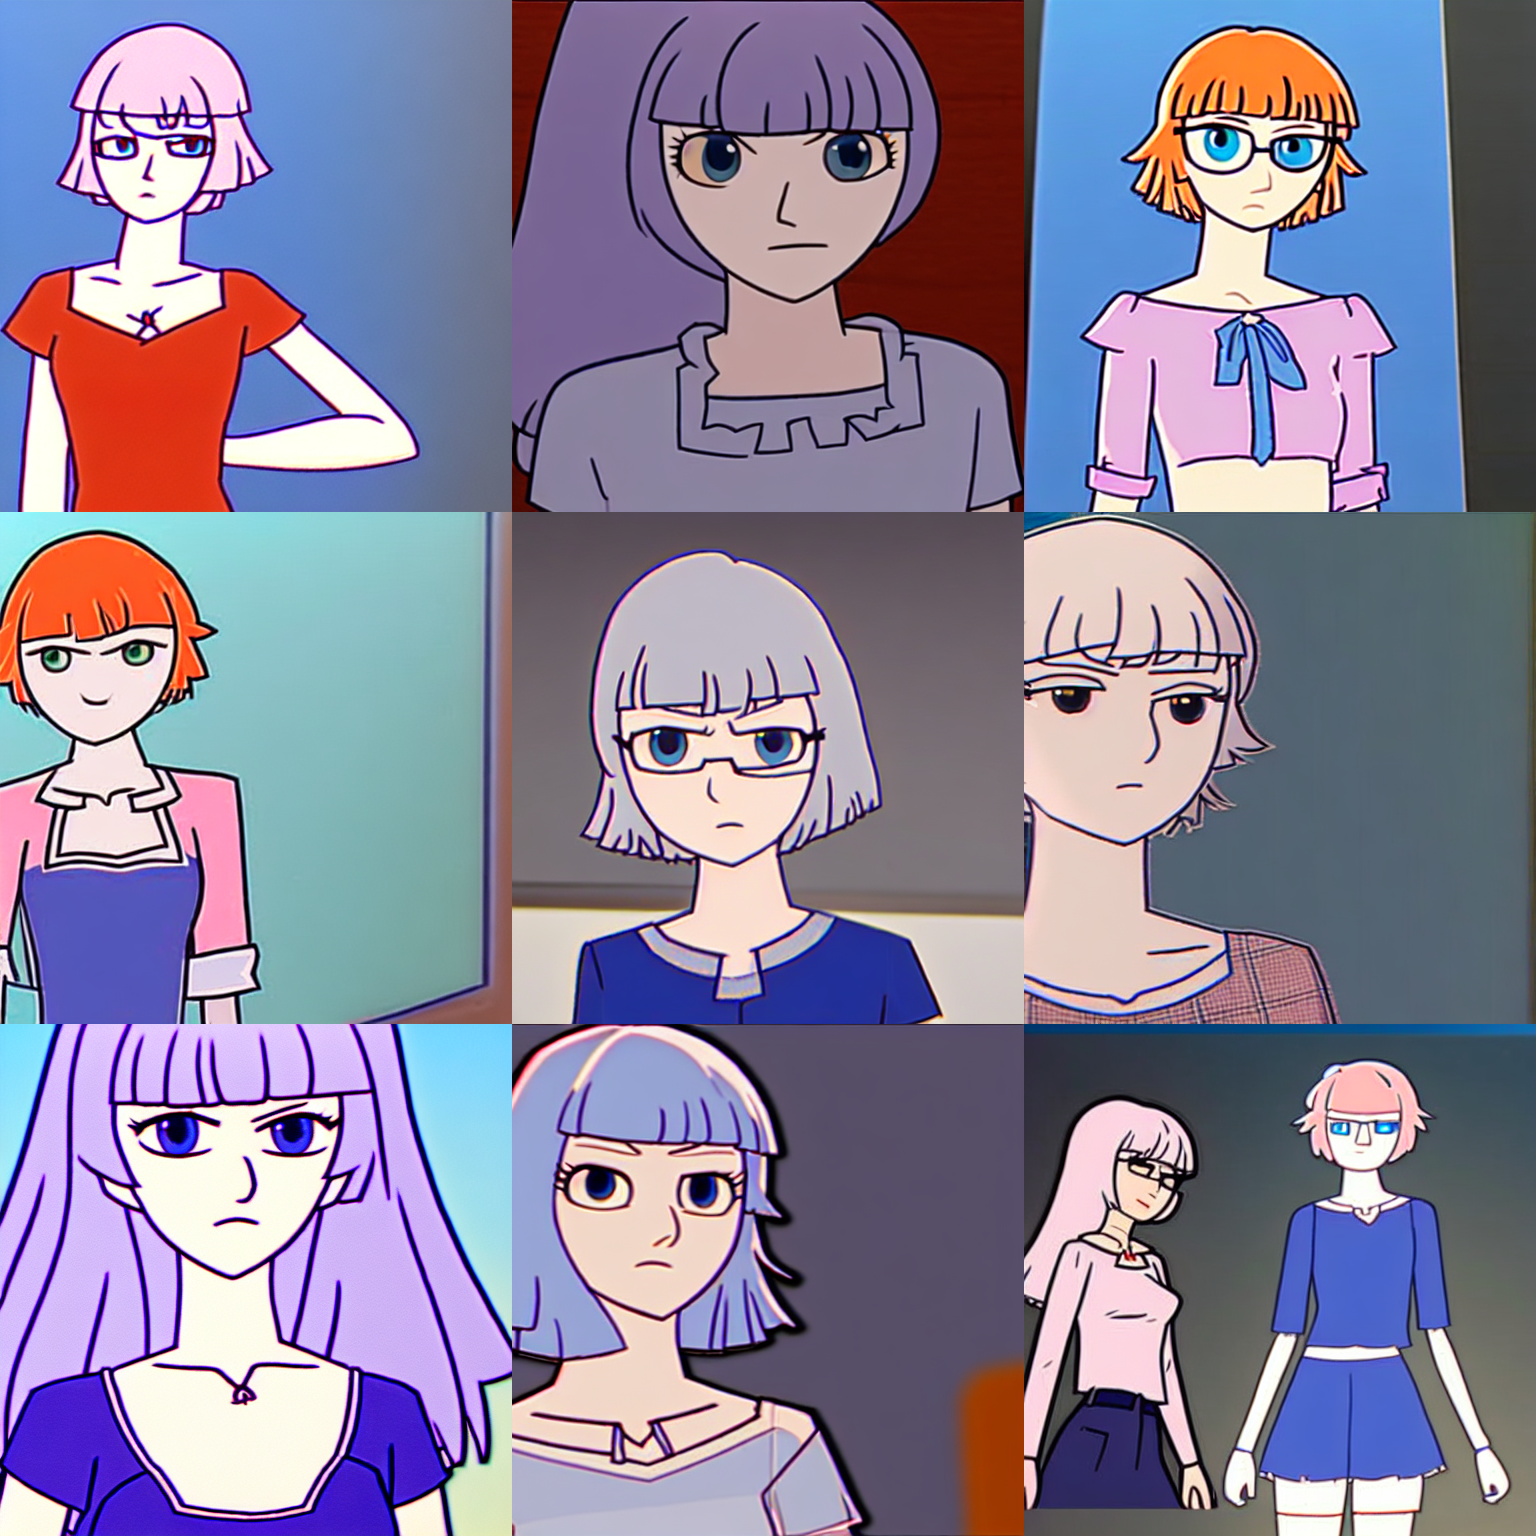

In [39]:
# Prompt and render

import time

prompt = "a high resolution drawing of <msa_brittany>, toned, sharp, 8k, highly detailed, correct anatomy"

t0 = time.time()
tz = t0
num_samples = 3 #@param {type:"number"}
num_rows = 3 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=100, guidance_scale=15).images
    all_images.extend(images)
    t_ij = time.time() - t0
    print(f"{num_samples} images generated in: {t_ij} ({t_ij/num_samples}s/img)")
    t0 = time.time()
    
print(f"Total time taken: {time.time() - tz}")

grid = image_grid(all_images, num_samples, num_rows)
grid